In [1]:
# Importing the requried datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [2]:
# We apply a transformation on the input data by first converting
# it to a tensor and then applying normalization.
mnist_data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

# The spit for the validation set 
# 10% of the training set will be used as the validation set for 
# obtaining the best model possible
validation_set_ratio = 0.1


# Load the MNIST Dataset using torchvision.datasets
training_set = datasets.MNIST('MNIST_DATA',download=True,train=True,transform=mnist_data_transform)
train_dataset_size = len(training_set)

indices = list(range(train_dataset_size))

# Find the number of data points belonging to the training and validation sets
# and use it to find the index where to split.
split = int(np.floor(validation_set_ratio*train_dataset_size))

# Shuffle the data within each set
np.random.shuffle(indices)
# Get the indices of the data belonging to the training and the validation set.
train_indices,val_indices = indices[split:], indices[:split]

# Samples data randomly without replacement
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Get the data belonging to the test set
test_set = datasets.MNIST('MNIST_DATA',download=True,train=False,transform=mnist_data_transform)



# Using Pytorch's data loader class which is used to perform training and inference in a batchwise fashion. 
train_loader = torch.utils.data.DataLoader(training_set,batch_size=64,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(training_set,batch_size=64,sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=64,shuffle=True)


torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([4, 6, 7, 2, 0, 1, 8, 0, 5, 4, 1, 7, 8, 7, 8, 5, 6, 4, 7, 9, 2, 0, 6, 9,
        4, 3, 8, 4, 8, 8, 0, 9, 5, 7, 2, 6, 6, 8, 8, 6, 6, 7, 0, 9, 5, 3, 7, 5,
        7, 6, 4, 0, 5, 0, 7, 9, 2, 4, 0, 7, 3, 6, 3, 1])


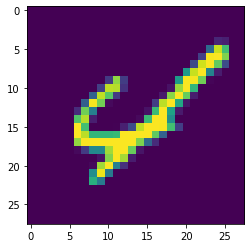

In [3]:
# Get a random batch of training data with their labels
# (64,1,28,28) represents a batch siz of 64 1 color channel and the width and height of the image which is 28.s
# Labels:  Length is the batch size containing the true labels of each image
images,labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
print(labels)

# Plot a sample image from the dataset
sample_image = plt.imshow(images[0].squeeze())
plt.show()

## Vanilla Neural Network Architecture
- Number of inputs : Size of one image vector = (784 x 1)
- Number of layers : User Input
- Hidden Layer Dimension : User Input (Default : 512)
- Hidden Layer Activation Function used : ReLU
- Output Layer Activation Function : Softmax applied with logarithm for Cross Entropy Loss calculation|}

In [4]:
# Deep Neural Network for MNIST Classification
class DNN(nn.Module):
    """
        Neural Network architecture for the MNIST Digit Classification task
        Attributes
        ---------------------
            num_layers : positive integer representing the number of hidden layers
            hidden_dim : The number of neurons in each hidden layer
            fc1: The series of neural connections from the input to the first hidden layer.
            layers: Intermediate hidden layers within the network
            out : Neural Connections from the last hidden layer to the output.

        Methods
        --------------------
            forward: The forward propogation phase of the neural network.
    """
    def __init__(self,hidden_dim=512,num_layers=2):
        super().__init__()
        self.num_layers=2
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(784,self.hidden_dim)
        self.layers = [nn.Linear(self.hidden_dim,self.hidden_dim) for i in range(num_layers-1)]
        self.layers = nn.ModuleList(self.layers)
        self.out = nn.Linear(self.hidden_dim,10)
    
    def forward(self,x):
        # The forward propogation of the input
        # Dimensions of x = (Batch Size, 784)
        # Output Dimensions = (Batch Size, 10)
       
        x = F.relu(self.fc1(x))
        for layer in self.layers:
            x = F.relu(layer(x))
        x = F.log_softmax(self.out(x),dim=1)
        return x

# Printing Sample Network Architecture
dnn = DNN(3)
dnn

DNN(
  (fc1): Linear(in_features=784, out_features=3, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
  )
  (out): Linear(in_features=3, out_features=10, bias=True)
)

### CNN Architecture

- Input : Batch of Images. Dimensions = (64,1,28,28) 
    - 64 represents the batch size
    - 1 represents the number of color channels
    - 28 represents the height of the image
    - 28 represents the width of the image

- Kernel size and hidden layer dimensions are user input. Default 3x3 and 256 respectively
- Output : Predictions Dimensions = (64,10)
    - each image sample has an associated distribution over the 10 different classes.


In [5]:
class CNN(nn.Module):

    """
        CNN architecture for the MNIST Digit Classification task
        Attributes
        ---------------------
            hidden_dim : The number of neurons in each hidden layer in the Deep Neural Network used after convolution
            kernel_size : The size of the kernel to be used for convolution operation.
            conv1 : The convolution layer of the neural network.
            fc1: The series of neural connections from the the convolution layer output to the first hidden layer.
            fc2: The second hidden layer 

            layers: Intermediate hidden layers within the network
            out : Neural Connections from the last hidden layer to the output.

        Methods
        --------------------
            forward: The forward propogation phase of the neural network.
    """

    def __init__(self,hidden_dim=256,kernel_size=3):

        
        super().__init__()
        self.hidden_dim  = hidden_dim
        self.kernel_size = kernel_size 

        #The colvolution layer
        self.conv1 = nn.Conv2d(1,128,kernel_size)
        
        # The width and the height of the image after applying convolution operation
        self.output_dims = (28-kernel_size+1)
        # The series of Dense layers after applying the convolution operation.
        self.fc1 = nn.Linear(self.output_dims*self.output_dims*128 ,self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.out = nn.Linear(self.hidden_dim,10)

    def forward(self,x):
       
        # Apply convolution operation
        x = F.relu(self.conv1(x))
        
        # Flattent the output from the convolution  layer
        batch_size = x.shape[0]
        x = x.view((batch_size,-1))
        
        # Pass the output from the convolution layer through a series of fully connected layers.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.out(x),dim=1)
        return x
        
# Print a sample model architecture
cnn = CNN(256,3)
cnn

CNN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

### Training Loop



In [6]:
# The method used for training the model given as input
# model = Model to train
# test_loader : DataLoader corresponding to the test examples
# train_cnn = Boolean variable indicating whether we are training a CNN or not

def test(model,test_loader,train_cnn=False):
    
    # Fix the model weights
    model.eval()
    accuracy = 0.0 # count of correctly classified points
    total = 0.0 # Total Number of data points

    with torch.no_grad():
        # Iterate through all the data points
        for imgs,labels in test_loader:
            # If we are not training a CNN we need to flatten the input to a vector
            if not train_cnn:
                imgs = imgs.view((imgs.shape[0],-1))
            
            # Output after the feed forward phase
            output = model(imgs)
            
            # Get the class label corresponding to the image
            _, predicted = torch.max(output,dim=1)
            # Add Batch Size to the total number of points
            total += labels.size(0)
            # Add the count of correctly classified points
            accuracy += (predicted==labels).sum().item()
    
    # Get the accuracy from counts of correctly classified points
    accuracy = (100*accuracy)/total
    print("Accuracy = " + str(accuracy))
    return accuracy

def train(model,epochs,train_loader,valid_loader=None,train_cnn=False,save_file_name='dnn2.pth'):
    # Error Function
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.SGD(model.parameters(),lr=0.01)
    
    # Keeping Track of validation loss and saving the model when the validation loss becomes less
    min_valid_loss = np.inf
    # Perform training for this number of epochs
    for e in range(epochs):
        # Loss in each iteration of the training loop
        running_loss = 0
        # Set the model for training
        model.train()
        # Iterate through all the data points
        for imgs,labels in train_loader:
            # If we are not training a CNN we need to flatten the input to a vector
            if not train_cnn:
                imgs = imgs.view((imgs.shape[0],-1))
            
        
            optimizer.zero_grad()
            # Output from the feed forward phase
            output = model(imgs)
            # Loss corresponding to the input
            loss = criterion(output,labels)
            # Propogate the loss backward for training for getting gradients.
            loss.backward()
            # Perform gradient descent step
            optimizer.step()
            # Add to total loss
            running_loss += loss.item()
        # Get the loss value corresponding to the current epoch
        print("Epoch " + str(e) + " Loss Value = "  +str(running_loss/len(train_loader)))
        
        # Get the running loss value
        running_loss = 0.0
        # Fix the model weights
        model.eval()
        # Iterate through all the data points
        for imgs,labels in valid_loader:
            # If we are not training a CNN we need to flatten the input to a vector
            if not train_cnn:
                imgs = imgs.view((imgs.shape[0],-1))
            # Get the ouput from the model
            target = model(imgs)
            # Calculate the loss
            loss = criterion(target,labels)
            # Add to the total loss for computing the average loss
            running_loss += loss.item()
        # Average loss
        averaged_loss = running_loss/len(valid_loader)
        
        # Perform training
        print("Epoch " + str(e) + " Validation Loss Value = "  + str(averaged_loss))
        if averaged_loss < min_valid_loss:
            min_valid_loss = averaged_loss
            # Save the model parameters if the validation loss is decreasing
            torch.save(model.state_dict(),"models/"+save_file_name,)
            print("Saving Model")
    # Load with the best learned parameters
    print("Loaded with best learned parameters")
    model.load_state_dict(torch.load("models/"+save_file_name))


 

### 2a

In [7]:
# Store the DNN accuracies as the number of layer changes The number of 
# neurons in the hidden layer is 512.

dnn_accuracies_layers = []
hidden_dim = 512
num_layers = [2,3,4] # Number of layers we are using 
print("Hidden Dimension size used" + str(hidden_dim))

for no in num_layers:
    print("No of Hidden Layers = " + str(no))
    print("------------------------------------")
    # Create the model
    dnn = DNN(hidden_dim,no)
    # Train the neural network using train_loader,val_loader for 30 epochs
    train(dnn,30,train_loader,val_loader,train_cnn=False,save_file_name='dnn_num_hidden_'+str(no)+'.pth')
    # Accuracy of the trained model
    accuracy = test(dnn,test_loader,train_cnn=False)
    print(" Accuracy for No of Hidden Layers =  "+ str(no) + " = " + str(accuracy))
    # Append the accuracies which will be used for plotting
    dnn_accuracies_layers.append(accuracy)
# Print the DNN accuracies
print(dnn_accuracies_layers )


Hidden Dimension size used512
No of Hidden Layers = 2
------------------------------------
Epoch 0 Loss Value = 0.9412889924447684
Epoch 0 Validation Loss Value = 0.4154639302733097
Saving Model
Epoch 1 Loss Value = 0.36991052241263234
Epoch 1 Validation Loss Value = 0.35601522932027246
Saving Model
Epoch 2 Loss Value = 0.31519380112959877
Epoch 2 Validation Loss Value = 0.29324578969402515
Saving Model
Epoch 3 Loss Value = 0.28367600845111207
Epoch 3 Validation Loss Value = 0.26742545368665077
Saving Model
Epoch 4 Loss Value = 0.2590001640196943
Epoch 4 Validation Loss Value = 0.25732342700691935
Saving Model
Epoch 5 Loss Value = 0.236835368101207
Epoch 5 Validation Loss Value = 0.2275099440457973
Saving Model
Epoch 6 Loss Value = 0.21691628659400047
Epoch 6 Validation Loss Value = 0.21240150009063966
Saving Model
Epoch 7 Loss Value = 0.19918547550843085
Epoch 7 Validation Loss Value = 0.19983971281413068
Saving Model
Epoch 8 Loss Value = 0.18310248660877065
Epoch 8 Validation Loss Va

Epoch 14 Validation Loss Value = 0.10391333616001809
Saving Model
Epoch 15 Loss Value = 0.08136558693710061
Epoch 15 Validation Loss Value = 0.12231189626804058
Epoch 16 Loss Value = 0.07488309405799248
Epoch 16 Validation Loss Value = 0.09520021733887335
Saving Model
Epoch 17 Loss Value = 0.06926190092722705
Epoch 17 Validation Loss Value = 0.09669331085689842
Epoch 18 Loss Value = 0.06446579176136977
Epoch 18 Validation Loss Value = 0.08793483143474193
Saving Model
Epoch 19 Loss Value = 0.05936208478962976
Epoch 19 Validation Loss Value = 0.09792053976908643
Epoch 20 Loss Value = 0.05658776348873849
Epoch 20 Validation Loss Value = 0.09721909927085359
Epoch 21 Loss Value = 0.05131479248876785
Epoch 21 Validation Loss Value = 0.08422473824999117
Saving Model
Epoch 22 Loss Value = 0.049031016151740776
Epoch 22 Validation Loss Value = 0.0970563645117936
Epoch 23 Loss Value = 0.04467383989544532
Epoch 23 Validation Loss Value = 0.07841069914123162
Saving Model
Epoch 24 Loss Value = 0.042

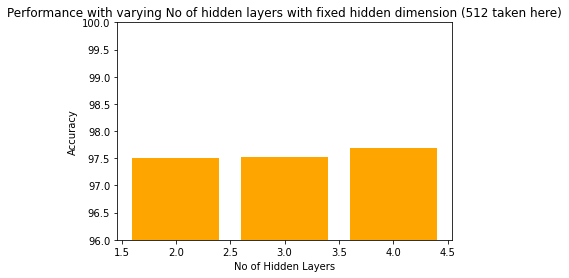

In [9]:
# Plot the barchart where each bar represents the accuracy corresponding to a particular choice of the
# number of hidden layers
plt.bar(num_layers, dnn_accuracies_layers, align='center', alpha=1,color='orange')
plt.ylabel('Accuracy')
plt.xlabel('No of Hidden Layers')
plt.ylim(96,100)
plt.title('Performance with varying No of hidden layers with fixed hidden dimension (512 taken here)')
plt.show()

### Performance
---------------

Accuracy when the number of hidden layers is 2 = **97.51**

Accuracy when the number of hidden layers is 3 = **97.52**

We notice that there is only a slight increase in the accuracy when the number of hidden layers changes

### 2b, 2c

In [7]:
# Store the CNN accuracies as the filter dimensions change. The number of 
# neurons in the hidden layer is 256.
cnn_accuracies_filter = []
hidden_dim = 256
filter_sizes = [1,2,3,4,5] # The filters we are using
print("Hidden Dimension size used" + str(hidden_dim))
for filter in filter_sizes:
    print("Filter Size = " + str(filter) + "x" + str(filter))
    print("------------------------------------")
    # Create the model
    cnn = CNN(hidden_dim,filter)
    # Train the CNN model.
    train(cnn,20,train_loader,val_loader,train_cnn=True,save_file_name='cnn_256_filter_size_'+str(filter)+'.pth')
    accuracy = test(cnn,test_loader,train_cnn=True)
    print(" Accuracy for filter size "+ str(filter) + " x " + str(filter) + " = " + str(accuracy))
    cnn_accuracies_filter.append(accuracy)

print(cnn_accuracies_filter)


Hidden Dimension size used256
Filter Size = 1x1
------------------------------------
Epoch 0 Loss Value = 0.6674207157998289
Epoch 0 Validation Loss Value = 0.3695680492735924
Saving Model
Epoch 1 Loss Value = 0.30798541712111205
Epoch 1 Validation Loss Value = 0.30116574910092864
Saving Model
Epoch 2 Loss Value = 0.24313866046049867
Epoch 2 Validation Loss Value = 0.2325202262306467
Saving Model
Epoch 3 Loss Value = 0.20040077444218912
Epoch 3 Validation Loss Value = 0.2146385985010482
Saving Model
Epoch 4 Loss Value = 0.1718054811902768
Epoch 4 Validation Loss Value = 0.17089946433267694
Saving Model
Epoch 5 Loss Value = 0.1506470901123579
Epoch 5 Validation Loss Value = 0.15481961443227657
Saving Model
Epoch 6 Loss Value = 0.13273811943264086
Epoch 6 Validation Loss Value = 0.1816406867843359
Epoch 7 Loss Value = 0.11987386346613697
Epoch 7 Validation Loss Value = 0.13414591667737732
Saving Model
Epoch 8 Loss Value = 0.10874404876837197
Epoch 8 Validation Loss Value = 0.128344241440

Epoch 13 Validation Loss Value = 0.0544245552415266
Saving Model
Epoch 14 Loss Value = 0.02122851132271233
Epoch 14 Validation Loss Value = 0.06941269520927776
Epoch 15 Loss Value = 0.01860946254949284
Epoch 15 Validation Loss Value = 0.054162221953292636
Saving Model
Epoch 16 Loss Value = 0.01681414269428409
Epoch 16 Validation Loss Value = 0.05964812502126269
Epoch 17 Loss Value = 0.015057793805103692
Epoch 17 Validation Loss Value = 0.0516486491938617
Saving Model
Epoch 18 Loss Value = 0.013383077722378251
Epoch 18 Validation Loss Value = 0.051102379081830226
Saving Model
Epoch 19 Loss Value = 0.011834821893524056
Epoch 19 Validation Loss Value = 0.05218910097151975
Loaded with best learned parameters
Accuracy = 98.55
 Accuracy for filter size 4 x 4 = 98.55
Filter Size = 5x5
------------------------------------
Epoch 0 Loss Value = 0.4887986897548299
Epoch 0 Validation Loss Value = 0.23641774866809237
Saving Model
Epoch 1 Loss Value = 0.20094711399721027
Epoch 1 Validation Loss Valu

### CNN vs DNN
------------

**The CNN Model having filter size 3 and a hidden layer dimension of 3 gave an accuracy of 98.28 compared to the DNN which gave 97% accuracy**
- Even all the filter sizes with same hidden layer dimensions gave more accuracy than the Vanilla Deep Neural Networks

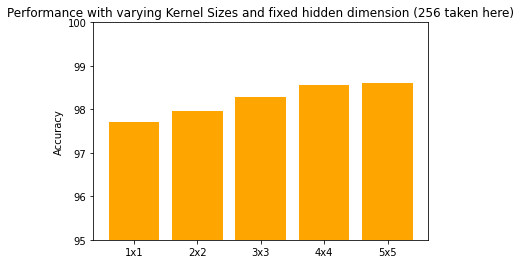

In [16]:
# Labels to be used for x axis
x_labels = ['1x1','2x2','3x3','4x4','5x5']

# Plot the bar graphs corresponding to the different choices of filter size
plt.bar(filter_sizes, cnn_accuracies_filter, align='center', alpha=1,color='orange')
# X axis labels
plt.xticks(filter_sizes, x_labels)
plt.ylabel('Accuracy')
plt.ylim(95,100)
plt.title('Performance with varying Kernel Sizes and fixed hidden dimension (256 taken here)')

plt.show()

### Performance with varying Kernel Sizes
- We see an increase in the performance as the dimensions of the filter changes
- We can see a notable increase in accuracies as filter size changes compared to DNN where the increase in accuracy as the number of hidden layers increases is very little

In [17]:
# Store the CNN accuracies as the number of hidden layer neurons change. 
# The filter used is 3x3

hidden_dims = [32,64,128,256,512]
filter_size = 3

# Store the accuracies
cnn_accuracies_hidden_dims = []
filter_size = 3

print("Filter Size Used = " + str(filter_size))
for dim in hidden_dims:
    print("Hidden Dimension size = " + str(dim))
    print("------------------------------------")
    # Get the model
    cnn = CNN(dim,filter_size)
    # Train the CNN model for 20 epochs
    train(cnn,20,train_loader,val_loader,train_cnn=True,save_file_name='cnn_3_hidden_size_'+str(dim)+'.pth')
    # Obtain the accuracy for the model.
    accuracy = test(cnn,test_loader,train_cnn=True)
    print(" Accuracy for Hidden dimension size "+ str(dim) + " = " + str(accuracy))
    # Append the accuracy to the cnn_accuracies_hidden_dims
    cnn_accuracies_hidden_dims.append(accuracy)

print(cnn_accuracies_hidden_dims)


Filter Size Used = 3
Hidden Dimension size = 32
------------------------------------
Epoch 0 Loss Value = 0.6980304718194132
Epoch 0 Validation Loss Value = 0.37004816024861437
Saving Model
Epoch 1 Loss Value = 0.28388147876637665
Epoch 1 Validation Loss Value = 0.23026473134597567
Saving Model
Epoch 2 Loss Value = 0.21394748225260826
Epoch 2 Validation Loss Value = 0.2050491360590813
Saving Model
Epoch 3 Loss Value = 0.17243502969231228
Epoch 3 Validation Loss Value = 0.17605472296634886
Saving Model
Epoch 4 Loss Value = 0.14154443841966055
Epoch 4 Validation Loss Value = 0.14146928162254552
Saving Model
Epoch 5 Loss Value = 0.11737339743920625
Epoch 5 Validation Loss Value = 0.1373134892275359
Saving Model
Epoch 6 Loss Value = 0.10003071282195784
Epoch 6 Validation Loss Value = 0.11709300084832183
Saving Model
Epoch 7 Loss Value = 0.08702104948725886
Epoch 7 Validation Loss Value = 0.10649458765785427
Saving Model
Epoch 8 Loss Value = 0.07706520167594308
Epoch 8 Validation Loss Value

Epoch 13 Validation Loss Value = 0.06793014798313379
Epoch 14 Loss Value = 0.026066277168141635
Epoch 14 Validation Loss Value = 0.060145274091987534
Saving Model
Epoch 15 Loss Value = 0.022809592660343256
Epoch 15 Validation Loss Value = 0.06883292224634677
Epoch 16 Loss Value = 0.020299656354707457
Epoch 16 Validation Loss Value = 0.05702528306233518
Saving Model
Epoch 17 Loss Value = 0.01807061841027807
Epoch 17 Validation Loss Value = 0.05806788847969964
Epoch 18 Loss Value = 0.015988547884460795
Epoch 18 Validation Loss Value = 0.055463331383702526
Saving Model
Epoch 19 Loss Value = 0.01439041965732117
Epoch 19 Validation Loss Value = 0.05781042709837648
Loaded with best learned parameters
Accuracy = 98.45
 Accuracy for Hidden dimension size 256 = 98.45
Hidden Dimension size = 512
------------------------------------
Epoch 0 Loss Value = 0.5050550987193653
Epoch 0 Validation Loss Value = 0.3109227701070461
Saving Model
Epoch 1 Loss Value = 0.22870059461019474
Epoch 1 Validation Lo

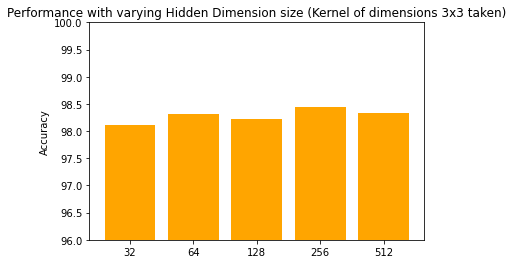

In [18]:
# X axis range of values
x_axis = np.arange(len(hidden_dims))
# Plot the bar graph
plt.bar(x_axis, cnn_accuracies_hidden_dims, align='center', alpha=1,color='orange')
plt.xticks(x_axis, hidden_dims)
plt.ylabel('Accuracy')
plt.ylim(96,100)
plt.title('Performance with varying Hidden Dimension size (Kernel of dimensions 3x3 taken)')

plt.show()

### Performance with varying hidden layer dimenions

We cannot see any consistent pattern as the dimension of the fully connected layers changes as we saw in the case of filter sizes
